In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
import seaborn as sns

# PREPARING THE DATA

In [2]:
df = pd.read_csv("BTC_USD_2014-11-04_2021-12-03-CoinDesk.csv",
                 parse_dates = ["Date"],
                 index_col = ["Date"])
df

,Currency,Closing Price (USD),24h Open (USD),24h High (USD),24h Low (USD)
Date,,,,,
2014-11-04,BTC,324.467934,323.826186,333.539527,323.106623
2014-11-05,BTC,328.644408,324.424164,330.671610,320.902900
2014-11-06,BTC,337.921358,328.653046,342.384170,328.597125
2014-11-07,BTC,348.992860,337.921358,352.585895,336.236830
2014-11-08,BTC,341.459753,348.992860,351.651854,340.196145
...,...,...,...,...,...
2021-11-29,BTC,57303.185972,54784.900000,57461.551028,53359.800000
2021-11-30,BTC,57834.357549,57305.932502,58890.733509,56770.710000
2021-12-01,BTC,56973.182042,57834.367211,59223.380063,55948.430857


In [4]:
df_cp = pd.DataFrame(df["Closing Price (USD)"]).rename(columns = {"Closing Price (USD)":"Price"})
df_cp

,Price
Date,
2014-11-04,324.467934
2014-11-05,328.644408
2014-11-06,337.921358
2014-11-07,348.992860
2014-11-08,341.459753
...,...
2021-11-29,57303.185972
2021-11-30,57834.357549
2021-12-01,56973.182042


In [5]:
window_size = 7
horizon_size = 1
# splitting the data into windows and horizon
df_win = df_cp.copy()
for i in range(window_size):
    df_win[f"Price + {i+1}"] = df_cp["Price"].shift(periods = i+1)
df_win

,Price,Price + 1,Price + 2,Price + 3,Price + 4,Price + 5,Price + 6,Price + 7
Date,,,,,,,,
2014-11-04,324.467934,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-05,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN,NaN
2014-11-06,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN,NaN
2014-11-07,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN,NaN
2014-11-08,341.459753,348.992860,337.921358,328.644408,324.467934,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-11-29,57303.185972,54784.900000,53712.210000,58959.315555,57193.709727,57576.849631,56309.762162,58684.500000
2021-11-30,57834.357549,57303.185972,54784.900000,53712.210000,58959.315555,57193.709727,57576.849631,56309.762162
2021-12-01,56973.182042,57834.357549,57303.185972,54784.900000,53712.210000,58959.315555,57193.709727,57576.849631


In [7]:
x = df_win.drop("Price", axis = 1).dropna()
y = df_win.dropna()["Price"]

In [8]:
# splitting into training and testing data
xtrain = x[:int(len(x)*0.8)]
ytrain = y[:int(len(y)*0.8)]
xtest = x[int(len(x)*0.8):]
ytest = y[int(len(x)*0.8):]
xtrain.shape, ytrain.shape, xtest.shape, ytest.shape

((2064, 7), (2064,), (516, 7), (516,))

In [9]:
# using the tf.data api to fasten the training process
train_features = tf.data.Dataset.from_tensor_slices(xtrain)
train_labels = tf.data.Dataset.from_tensor_slices(ytrain)
test_features = tf.data.Dataset.from_tensor_slices(xtest)
test_labels = tf.data.Dataset.from_tensor_slices(ytest)

In [10]:
train_df = tf.data.Dataset.zip((train_features, train_labels))
test_df = tf.data.Dataset.zip((test_features, test_labels))
train_df = train_df.batch(128).prefetch(tf.data.AUTOTUNE)
test_df = test_df.batch(128).prefetch(tf.data.AUTOTUNE)

# BUILDING A FUNCTION THAT RETURNS ENSEMBLE MODELS

In [11]:
def ensemble_models(window_size = 7,
                    horizon_size = 1,
                    train_df = train_df,
                    test_df = test_df,
                    iters = 10,
                    epochs = 1000,
                    loss_funcs = ["mae","mse","mape"]):
    ensemble_models = []
    for loss_func in loss_funcs:
        for i in range(iters):
            model = tf.keras.Sequential([
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(128, activation="relu"),
                tf.keras.layers.Dense(horizon_size)
            ])
            model.compile(loss = loss_func, optimizer = tf.keras.optimizers.Adam(), metrics = ["mae"])
            model.fit(train_df,
                      epochs = epochs,
                      validation_data = test_df,
                      verbose = 0,
                      callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",
                                                                        patience = 100,
                                                                        verbose = 1),
                                   tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
                                                                    patience = 200,
                                                                    restore_best_weights = True)
                                   ])
            ensemble_models.append(model)
    return ensemble_models

In [12]:
ensembled_models = ensemble_models()


Epoch 00312: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00156: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00384: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00146: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00336: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00436: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00586: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00690: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00891: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.

Epoch 00992: ReduceLROnPlateau reducing learning rate to 1.0000000656873453e-06.

Epoch 00406: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00373: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00473: Re

# EVALUATING THE ENSEMBLE

In [13]:
preds_ensemble = []
for model in ensembled_models:
    preds = model.predict(test_df)
    preds_ensemble.append(preds)
preds_ensemble = np.array(preds_ensemble)
preds_ensemble = tf.squeeze(preds_ensemble).numpy()
preds_ensemble.shape

(30, 516)

In [14]:
predictions_reduced = tf.reduce_mean(preds_ensemble, axis = 0).numpy()
predictions_reduced.shape

(516,)

In [15]:
from helperfuncs import model_report
ensemble_report1 = model_report(ytest, predictions_reduced)
ensemble_report1

{'MEAN ABSOLUTE ERROR': 1054.0858,
 'MEAN SQUARED ERROR': 2528749.2,
 'ROOT MEAN SQUARED ERROR': 1590.2041,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 2.7745252}

In [16]:
predictions_reduced_median = np.median(preds_ensemble, axis=0)
ensemble_report2 = model_report(ytest, predictions_reduced_median)
ensemble_report2

{'MEAN ABSOLUTE ERROR': 1053.2626,
 'MEAN SQUARED ERROR': 2528019.2,
 'ROOT MEAN SQUARED ERROR': 1589.9746,
 'MEAN ABSOLUTE PERCENTAGE ERROR': 2.77153}

# PLOTTING THE PREDICTIONS

In [17]:
timesteps = df.index.to_numpy()
timesteps

array(['2014-11-04T00:00:00.000000000', '2014-11-05T00:00:00.000000000',
       '2014-11-06T00:00:00.000000000', ...,
       '2021-12-01T00:00:00.000000000', '2021-12-02T00:00:00.000000000',
       '2021-12-03T00:00:00.000000000'], dtype='datetime64[ns]')

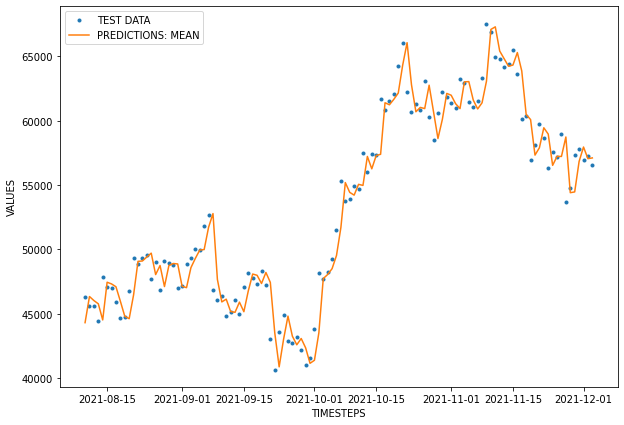

In [18]:
from helperfuncs import plot_timeseries
plt.figure(figsize=(10,7))
plot_timeseries(timesteps[-int(len(ytest)):], ytest, label = "TEST DATA", start = 400)
plot_timeseries(timesteps[-int(len(ytest)):], predictions_reduced, format = '-', label = "PREDICTIONS: MEAN", start = 400)

# PLOTTING THE 95% PREDICTION RANGE

In [19]:
std_dev = tf.math.reduce_std(preds_ensemble, axis = 0).numpy()
interval = std_dev*1.96
lower, upper = predictions_reduced-interval, predictions_reduced+interval
lower,upper

(array([ 9067.42  ,  9054.516 ,  9242.583 ,  9228.454 ,  9366.399 ,
         9224.493 ,  9225.973 ,  9180.737 ,  9244.563 ,  9188.491 ,
         9202.005 ,  9148.62  ,  9092.02  ,  9093.675 ,  9125.998 ,
         9156.225 ,  9121.775 ,  9303.895 ,  9485.056 ,  9579.199 ,
         9528.211 ,  9650.612 ,  9883.7295, 10885.238 , 10958.331 ,
        11095.231 , 11102.201 , 11317.119 , 11726.084 , 11121.167 ,
        11095.833 , 11120.559 , 11618.165 , 11678.733 , 11557.851 ,
        11688.171 , 11657.208 , 11796.941 , 11404.519 , 11451.065 ,
        11679.835 , 11740.    , 11753.261 , 11837.03  , 12206.807 ,
        11960.31  , 11699.571 , 11756.394 , 11524.811 , 11539.698 ,
        11596.301 , 11689.244 , 11321.391 , 11359.014 , 11282.925 ,
        11440.218 , 11416.311 , 11607.578 , 11611.761 , 11834.686 ,
        11415.878 , 10225.025 , 10210.853 , 10119.945 , 10135.563 ,
        10254.903 , 10078.911 , 10116.45  , 10267.842 , 10346.871 ,
        10373.629 , 10288.334 , 10569.76  , 1073

<ipython-input-21-a78f45638de3>:4: MatplotlibDeprecationWarning: Since 3.2, the parameter *where* must have the same size as [18949.0 18950.0 18951.0 18952.0 18953.0 18954.0 18955.0 18956.0 18957.0
 18958.0 18959.0 18960.0 18961.0 18962.0 18963.0 18964.0] in fill_betweenx(). This will become an error two minor releases later.
  plt.fill_between(xtest.index[500:],(lower)[500:], (upper)[500:], "b",label="Prediction Intervals")


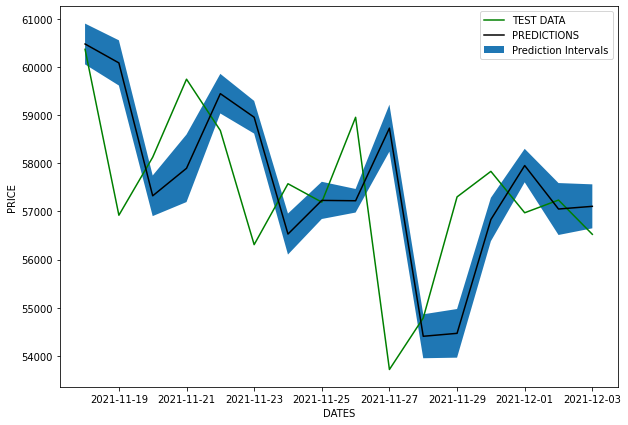

In [21]:
plt.figure(figsize=(10,7))
plt.plot(xtest.index[500:], ytest[500:], "g", label = "TEST DATA")
plt.plot(xtest.index[500:], predictions_reduced[500:],"k-", label = "PREDICTIONS")
plt.fill_between(xtest.index[500:],(lower)[500:], (upper)[500:], "b",label="Prediction Intervals")
plt.xlabel("DATES")
plt.ylabel("PRICE")
plt.legend(loc = "upper right")